# Hardware efficiency

In [1]:
import csv
import re
import warnings

warnings.filterwarnings('ignore')

miners = []
with open('miners.csv') as datafile:
    reader = csv.DictReader(datafile)
    for rowdict in reader:
        rowdict['Power (kW)'] = float(re.search('([0-9])+',rowdict['Power']).group(0))/1000.0
        rowdict['Hashrate (Th/s)'] = float(re.search('([0-9])+',rowdict['Hashrate']).group(0))
        rowdict['alpha (kWh/Thash)']=rowdict['Power (kW)']/(rowdict['Hashrate (Th/s)']*3600)
        miners.append(rowdict)

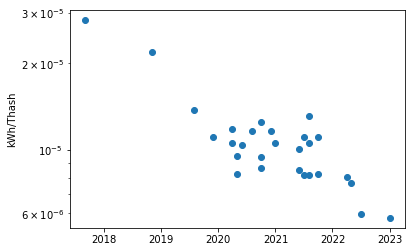

In [2]:
import matplotlib.pyplot as plt
import datetime as dt

plt.scatter(x=[dt.datetime.strptime(m['Date'], '%b %Y').date() for m in miners], 
         y=[m['alpha (kWh/Thash)'] for m in miners])
plt.ylabel('kWh/Thash')
plt.yscale('log')

# Mining share of value

In [3]:
import pandas as pd

rev = pd.read_csv('miners-revenue.csv')
mkt = pd.read_csv('market-cap.csv')
fees = pd.read_csv('transaction-fees-usd.csv')
rev.rename({'bbbbb﻿Timestamp': 'Timestamp'}, axis=1, inplace=True)
rev.set_index('Timestamp', inplace=True)
mkt.set_index('Timestamp', inplace=True)
fees.set_index('Timestamp', inplace=True)

df = mkt.merge(rev, how='outer', on='Timestamp', sort=True)
df = df.merge(fees, how='outer', on='Timestamp', sort=True)
df.index = pd.to_datetime(df.index)
df.interpolate(method='time', inplace=True)

In [4]:
vt = df.apply(lambda row: row['miners-revenue']*365.25/row['market-cap'], axis=1)
vtf = df.apply(lambda row: row['transaction-fees-usd']*365.25/row['market-cap'], axis=1)

Text(0.5, 1.0, 'annual_miner_rev/mkt_cap')

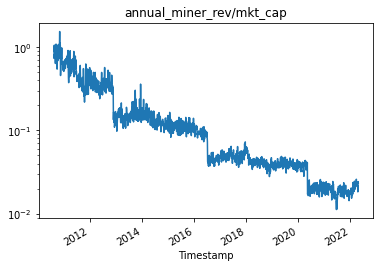

In [5]:
vt.plot()
plt.yscale('log')
plt.title('annual_miner_rev/mkt_cap')

Text(0.5, 1.0, 'annual_fees/mkt_cap')

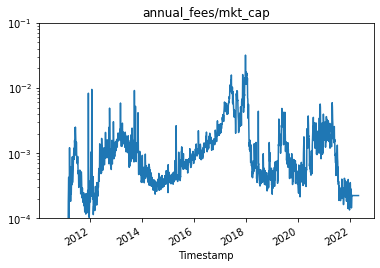

In [6]:
vtf.plot()
plt.yscale('log')
plt.ylim([1e-4,0.1])
plt.title('annual_fees/mkt_cap')

Text(0.5, 1.0, 'fees/miner_rev')

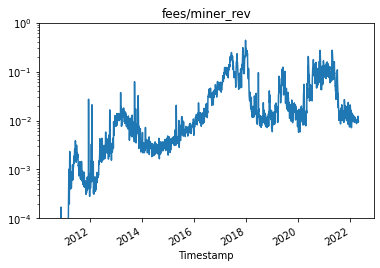

In [7]:
fr = df.apply(lambda row: row['transaction-fees-usd']/row['miners-revenue'], axis=1)
fr.plot()
plt.yscale('log')
plt.ylim([1e-4,1])
plt.title('fees/miner_rev')

# Fees as congestion price

In [8]:
txn_btc = pd.read_csv('estimated-transaction-volume.csv')
txn_btc['Timestamp'] = pd.to_datetime(txn_btc['Timestamp'])
txn_btc.set_index('Timestamp', inplace=True)

fees_btc = pd.read_csv('transaction-fees.csv')
fees_btc['Timestamp'] = pd.to_datetime(fees_btc['Timestamp'])
fees_btc.set_index('Timestamp', inplace=True)

txn_num = pd.read_csv('n-transactions.csv')
txn_num['Timestamp'] = pd.to_datetime(txn_num['Timestamp'])
txn_num.set_index('Timestamp', inplace=True)

block_size = pd.read_csv('avg-block-size.csv')
block_size['Timestamp'] = pd.to_datetime(block_size['Timestamp'])
block_size.set_index('Timestamp', inplace=True)

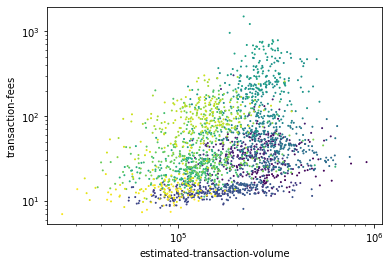

In [9]:
df2 = txn_btc.merge(fees_btc, how='outer', on='Timestamp', sort=True)
df2 = df2.merge(txn_num, how='outer', on='Timestamp', sort=True)
df2 = df2.merge(block_size, how='outer', on='Timestamp', sort=True)
df2.interpolate(method='time', inplace=True)
df2 = df2.loc[df2.index>pd.to_datetime('2012-07-01')]
df2.plot.scatter(x='estimated-transaction-volume',y='transaction-fees',
                 s=1, c=df2.index, cmap='viridis')
plt.yscale('log')
plt.xscale('log')

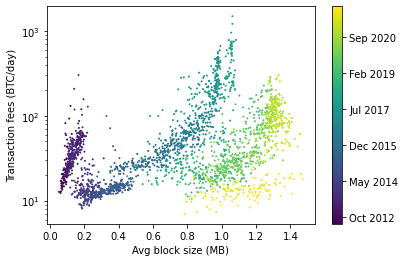

In [10]:
def timestamp_label(t):
    return dt.datetime.fromtimestamp(t/1e9).strftime('%b %Y')

plt.scatter(x=df2['avg-block-size'], y=df2['transaction-fees'],
                 s=1, c=df2.index, cmap='viridis')
plt.yscale('log')
plt.ylabel('Transaction fees (BTC/day)')
plt.xlabel('Avg block size (MB)')
cb=plt.colorbar()
cb.set_ticklabels([timestamp_label(t) for t in cb.get_ticks()])

In [11]:
mempool_size = pd.read_csv('mempool-size.csv')
mempool_size.set_index('Timestamp', inplace=True)
mempool_size.index = pd.to_datetime(mempool_size.index)

Text(0.5, 0, 'Mempool size (Bytes)')

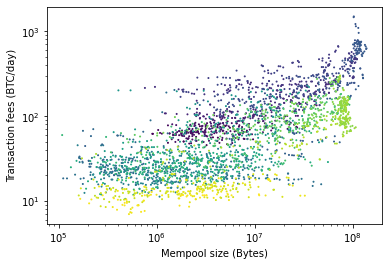

In [12]:
df3 = df2.merge(mempool_size, how='outer', on='Timestamp', sort=True)
df3 = df3.loc[df3.index>pd.to_datetime('2016-06-14')]
df3.interpolate(method='time', inplace=True)
plt.scatter(x=df3['mempool-size'], y=df3['transaction-fees'],
                 s=1, c=df3.index, cmap='viridis')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Transaction fees (BTC/day)')
plt.xlabel('Mempool size (Bytes)')

# TODO
Don't interpolate daily transaction fees from 1 out of 3 day sample, get daily data series.

# Yield

In [13]:
hash_rate = pd.read_csv('hash-rate.csv')
hash_rate.set_index('Timestamp', inplace=True)
hash_rate.index = pd.to_datetime(hash_rate.index)

rewards = pd.read_csv('block-rewards.csv')
rewards.set_index('DateTime', inplace=True)
rewards.index = pd.to_datetime(rewards.index)

Text(0, 0.5, 'BTC/TH')

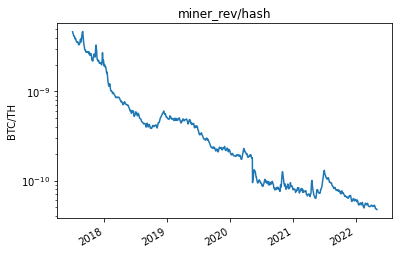

In [14]:
df4 = hash_rate.merge(fees_btc, how='outer',  left_on='Timestamp', right_on='Timestamp', sort=True)
df4 = df4.merge(rewards, how='outer', left_index=True, right_index=True, sort=True)
df4.interpolate(method='time', inplace=True)
df4 = df4.loc[df4.index>pd.to_datetime('2017-07-01')]
rh = df4.apply(lambda row: (row['transaction-fees']/(3600*24) + row['BTC']/600)/row['hash-rate'], axis=1)
rh.plot()
plt.yscale('log')
plt.title('miner_rev/hash')
plt.ylabel('BTC/TH')

Text(2022-04-25, 2e-07, '@nemozen')

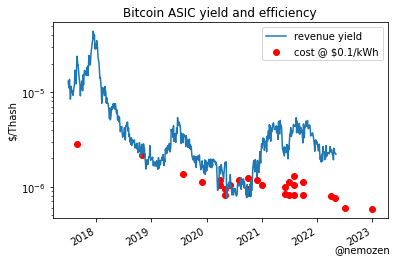

In [15]:
price_kwh = 0.1
df5 = df4.merge(df, how='outer', left_index=True, right_index=True, sort=True)
df5 = df5.loc[df5.index>pd.to_datetime('2017-07-01')]
df5.interpolate(method='time', inplace=True)
rh_usd = df5.apply(lambda row: (row['miners-revenue']/(3600*24))/row['hash-rate'], axis=1)
rh_usd.plot(label='revenue yield')
plt.yscale('log')
plt.ylabel('$/Thash')
plt.title('Bitcoin ASIC yield and efficiency')
plt.scatter(x=[dt.datetime.strptime(m['Date'], '%b %Y').date() for m in miners], 
            y=[m['alpha (kWh/Thash)']*price_kwh for m in miners], 
            color='red', label="cost @ ${}/kWh".format(price_kwh))
plt.legend()
plt.text("2022-04-25", 2e-7, '@nemozen')

# Global hash rate and power

Text(0.5, 1.0, 'Global hashrate')

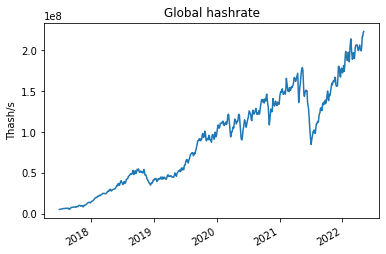

In [16]:
df5['hash-rate'].plot()
plt.ylabel('Thash/s')
plt.title('Global hashrate')

## Naive power (lower bound)

In [18]:
miners_df = pd.DataFrame(miners).set_index('Date')
miners_df.index=pd.to_datetime(miners_df.index)
miners_df.sort_values(by='alpha (kWh/Thash)', ascending=False, inplace=True)
miners_df.sort_index(inplace=True)
df6 = miners_df.merge(df5, how='outer', left_index=True, right_index=True, sort=True)
df6.interpolate(method='pad', inplace=True)
df6 = df6.loc[(df6.index>pd.to_datetime('2017-08-31')) & (df6.index<pd.to_datetime('2022-04-30'))]

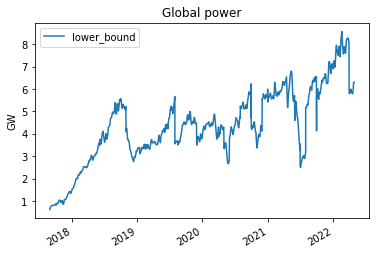

In [19]:
df6.apply(lambda row: row['alpha (kWh/Thash)']*row['hash-rate']*3600/1e6, axis=1).plot(label='lower_bound')
plt.ylabel('GW')
plt.title('Global power')
plt.legend()

The power consumption above assumes that all miners are at the latest alpha, i.e. 100% of the populationof miners switches to the most recent generation of machines as soon as it becomes available. This is obviously a lower bound on power since older less efficient machines continue to run as long as they are profitable.  

To get a more realistic estimate, let's model how the population distribution evolves as new generations of hardware are introduced.


## Population model

Let $t_i$ be the time at which the i-th generation of miner is launched. First, assume the cummulative number of units deployed of generation $i$ rises from zero at time $t_i$ asymptotically approaching a maximum $N_i$ but stops growing when the next generation is introduced. More precisely it follows $(1-e^{a(t_i-t)})N_i$ for $t_i < t \leq t_{i+1}$ and then stays constant after $t>t_{i+1}$.  Second, assume each machine has a given chance of dying or being retired which increases depends on how old it is, i.e. an individual machine deployed at time $\tau$ has a probability $e^{b(\tau-t)}$ of being still online at time t. The number of miners of generation $i$ still working at time $t$ is then:
$$P_i(t) = N_i\int_{t_i}^{\min(t, t_{i+1})} x_i(\tau) e^{b(\tau-t)} d\tau$$ 
where $x_i(\tau) = {d \over d\tau} (1 - e^{a(t_i - \tau})) = a e^{a(t_i - \tau)}$ is the number launched at time $\tau$. Substituting that in and solving the integral, the population at time $t$ is, for $t_i < t \leq t_{i+1}$:
$$P_i(t) = N_i{a \over a-b}\left( e^{b(t_i -t)} - e^{a(t_i -t)} \right) $$ 
and for $t >t_{i+1}$:
$$P_i(t) = N_i{a \over a-b}\left( e^{b(t_i -t)} - e^{b(t_{i+1} -t) + a(t_i - t_{i+1})} \right)$$

Our model is that at time $t$, the fraction of the population that is of generation $i$ is $P_i(t)/\sum_j{P_j(t)}$.

We assume

* the growth rate is such that half the potential is reached in half a year, so $a = ln(2)/(0.5yrs)$
* the half-life of a machine is 3 years, so $b = ln(2)/(3yrs)$
* $N_i$ is the same for all $i$ so it cancels out in the population fraction; this is not as unrealistic as it may seem since individual machines hash rate is increasing even as the global hash rate increases, and both increased about an order of magnitude from 2017 to 2021.

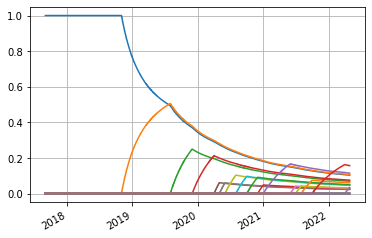

In [20]:
import math

b = math.log(2)/(3*365.25)
a = math.log(2)/(0.5*365.25)

def population_weights(t):
    p = []
    for tn,tn1 in list(zip(miners_df.index, list(miners_df.index[1:]) + [pd.Timestamp.max])):
        if tn > t:
            pn = 0
        else:
            pn = (math.exp(b*(tn-t).days) - 
                  math.exp(a*(tn-min(tn1,t)).days + b*min(tn1-t,pd.Timedelta(0)).days))
            pn *= a/(a-b)
        p.append(pn)
    s = sum(p)
    if s == 0:
        return [1.0] + [0]*(len(p)-1)
    return [pi/s for pi in p]

pop_dist = df6.apply(lambda row: population_weights(row.name), result_type='expand', axis=1)
pop_dist.plot(legend=False)
plt.grid()

This generates the population mix that we can see in the plot above. Comparing it to reports (e.g. that [machines released in 2017 had ~23% share in mid 2020](https://www.theblockcrypto.com/post/63892/report-bitcoin-antminer-s9-bitcoin-hash-rate)) seems to indicate our estimate of adoption rate is realistic but on the conservative side, and since machines are getting more efficient, it will give a reasonably tight upper bound on power consumption.

## Population-based power (upper bound)

Text(2022-01-01, -2, '@nemozen')

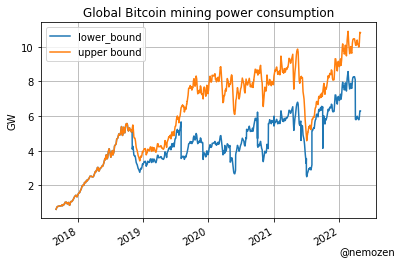

In [21]:
df6.apply(lambda row: row['alpha (kWh/Thash)']*row['hash-rate']*3600/1e6, axis=1).plot(label='lower_bound')
df6['alpha avg']=pop_dist.apply(lambda row: row.dot(miners_df['alpha (kWh/Thash)'].values), axis=1)
df6.apply(lambda row: row['alpha avg']*row['hash-rate']*3600/1e6, axis=1).plot(label='upper bound')
plt.ylabel('GW')
plt.title('Global Bitcoin mining power consumption')
plt.legend()
plt.grid()
plt.text("2022-01-01", -2, '@nemozen')